In [0]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import sqlite3
import csv
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
from sqlalchemy import create_engine # database connection
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from skmultilearn.adapt import mlknn
from skmultilearn.problem_transform import ClassifierChain
from skmultilearn.problem_transform import BinaryRelevance
from skmultilearn.problem_transform import LabelPowerset
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

# Stack Overflow: Tag Prediction

<h1>1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p style='font-size:18px'><b> Description </b></p>
<p>
Stack Overflow is the largest, most trusted online community for developers to learn, share their programming knowledge, and build their careers.<br />
<br />
Stack Overflow is something which every programmer use one way or another. Each month, over 50 million developers come to Stack Overflow to learn, share their knowledge, and build their careers. It features questions and answers on a wide range of topics in computer programming. The website serves as a platform for users to ask and answer questions, and, through membership and active participation, to vote questions and answers up or down and edit questions and answers in a fashion similar to a wiki or Digg. As of April 2014 Stack Overflow has over 4,000,000 registered users, and it exceeded 10,000,000 questions in late August 2015. Based on the type of tags assigned to questions, the top eight most discussed topics on the site are: Java, JavaScript, C#, PHP, Android, jQuery, Python and HTML.<br />
<br />
</p>

<p style='font-size:18px'><b> Problem Statemtent </b></p>
Suggest the tags based on the content that was there in the question posted on Stackoverflow.

<p style='font-size:18px'><b> Source:  </b> https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/</p>


<h2> 1.2 Source / useful links </h2>

Data Source : https://www.kaggle.com/c/facebook-recruiting-iii-keyword-extraction/data <br>
Youtube : https://youtu.be/nNDqbUhtIRg <br>
Research paper : https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/tagging-1.pdf <br>
Research paper : https://dl.acm.org/citation.cfm?id=2660970&dl=ACM&coll=DL

<h3> 3.3 Cleaning and preprocessing of Questions </h3>

<h3> 3.3.1 Preprocessing </h3>

<ol> 
    <li> Sample 1M data points </li>
    <li> Separate out code-snippets from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> Remove stop words (Except 'C') </li>
    <li> Remove HTML Tags </li>
    <li> Convert all the characters into small letters </li>
    <li> Use SnowballStemmer to stem the words </li>
</ol>

In [0]:
import nltk
nltk.download('stopwords')

def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\DELL\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [0]:
#http://www.sqlitetutorial.net/sqlite-python/create-tables/
def create_connection(db_file):
    """ create a database connection to the SQLite database
        specified by db_file
    :param db_file: database file
    :return: Connection object or None
    """
    try:
        conn = sqlite3.connect(db_file)
        return conn
    except Error as e:
        print(e)
 
    return None

def create_table(conn, create_table_sql):
    """ create a table from the create_table_sql statement
    :param conn: Connection object
    :param create_table_sql: a CREATE TABLE statement
    :return:
    """
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def checkTableExists(dbcon):
    cursr = dbcon.cursor()
    str = "select name from sqlite_master where type='table'"
    table_names = cursr.execute(str)
    print("Tables in the databse:")
    tables =table_names.fetchall() 
    print(tables[0][0])
    return(len(tables))

def create_database_table(database, query):
    conn = create_connection(database)
    if conn is not None:
        create_table(conn, query)
        checkTableExists(conn)
    else:
        print("Error! cannot create the database connection.")
    conn.close()

sql_create_table = """CREATE TABLE IF NOT EXISTS QuestionsProcessed (question text NOT NULL, code text, tags text, words_pre integer, words_post integer, is_code integer);"""
create_database_table("Processed.db", sql_create_table)

Tables in the databse:
QuestionsProcessed


__ we create a new data base to store the sampled and preprocessed questions __

<h1>4. Machine Learning Models </h1>

<h2> 4.1 Converting tags for multilabel problems </h2>

<table>
<tr>
<th>X</th><th>y1</th><th>y2</th><th>y3</th><th>y4</th>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>1</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>1</td><td>0</td><td>0</td><td>0</td>
</tr>
<tr>
<td>x1</td><td>0</td><td>1</td><td>0</td><td>0</td>
</tr>
</table>

__ We will sample the number of tags instead considering all of them (due to limitation of computing power) __

In [0]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

__ We consider top 15% tags which covers  99% of the questions __

<h2>4.2 Split the data into test and train (80:20) </h2>

In [0]:
#print("Number of data points in train data :", y_train.shape)
#print("Number of data points in test data :", y_test.shape)

<h2>4.3 Featurizing data </h2>

<h2> 4.5 Modeling with less data points (0.1M data points) and more weight to title and 500 tags only. </h2>

In [0]:
#Taking 0.1 Million entries to a dataframe.
write_db = 'D:\AppliedAI\Homework-n-Assignments\# 19 Stack overflow tagging\Titlemoreweight.db'
if os.path.isfile(write_db):
    conn_r = create_connection(write_db)
    if conn_r is not None:
        preprocessed_data = pd.read_sql_query("""SELECT question, Tags FROM QuestionsProcessed""", conn_r)
        preprocessed_data = preprocessed_data.head(100000)
conn_r.commit()
conn_r.close()

In [0]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])


In [0]:
preprocessed_data.head()


,question,tags
0,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding
1,dynam datagrid bind silverlight dynam datagrid...,c# silverlight data-binding columns
2,java.lang.noclassdeffounderror javax servlet j...,jsp jstl
3,java.sql.sqlexcept microsoft odbc driver manag...,java jdbc
4,better way updat feed fb php sdk better way up...,facebook api facebook-php-sdk


In [0]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 100000
number of dimensions : 2


In [0]:
type(preprocessed_data)

pandas.core.frame.DataFrame

In [0]:
total_size=preprocessed_data.shape[0]
train_size=int(0.80*total_size)

x_train=preprocessed_data.head(train_size)
x_test=preprocessed_data.tail(total_size - train_size)



__ Converting string Tags to multilable output variables __ 

__ Selecting 500 Tags __

In [0]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

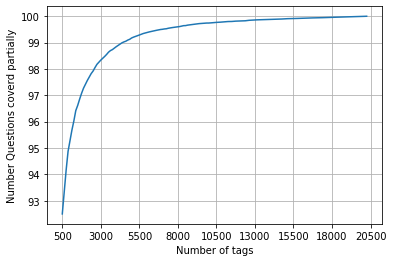

with  5500 tags we are covering  99.481 % of questions
with  500 tags we are covering  92.5 % of questions


In [0]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [0]:
# we will be taking 500 tags
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(500),"out of ", total_qs)

number of questions that are not covered : 7500 out of  100000


In [0]:
train_datasize = 80000

x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 80000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [0]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (80000, 500)
Number of data points in test data : (20000, 500)



# Use bag of words upto 2 grams and compute the micro f1 score with Logistic regression(OvR)



<h3> 4.5.2 Featurizing data with BOW vectorizer </h3>

In [0]:
start = datetime.now()
#vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
#                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,3))
vectorizer = CountVectorizer(min_df=0.00009, max_features=20000,tokenizer = lambda x: x.split(), ngram_range=(1,2))
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:00:29.595038


In [0]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (80000, 20000) Y : (80000, 500)
Dimensions of test data X: (20000, 20000) Y: (20000, 500)


<h3> 4.5.3 Applying Logistic Regression with OneVsRest Classifier </h3>

In [0]:
start = datetime.now()
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'))
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.09885
Hamming loss  0.00580972
Micro-average quality numbers
Precision: 0.2915, Recall: 0.4694, F1-measure: 0.3597
Macro-average quality numbers
Precision: 0.2078, Recall: 0.4114, F1-measure: 0.2675
              precision    recall  f1-score   support

           0       0.75      0.79      0.77      5519
           1       0.45      0.42      0.43      8190
           2       0.53      0.49      0.51      6529
           3       0.52      0.60      0.56      3231
           4       0.55      0.51      0.53      6430
           5       0.44      0.45      0.44      2879
           6       0.59      0.60      0.60      5086
           7       0.64      0.63      0.63      4533
           8       0.24      0.21      0.23      3000
           9       0.55      0.65      0.60      2765
          10       0.32      0.30      0.31      3051
          11       0.45      0.50      0.47      3009
          12       0.38      0.41      0.39      2630
          13       0.37      0.

In [0]:
joblib.dump(classifier, 'lr_with_more_title_weight.pkl') 

In [0]:
start = datetime.now()
classifier_2 = OneVsRestClassifier(LogisticRegression(penalty='l1'))
classifier_2.fit(x_train_multilabel, y_train)
predictions_2 = classifier_2.predict(x_test_multilabel)
print("Accuracy :",metrics.accuracy_score(y_test, predictions_2))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_2))


precision = precision_score(y_test, predictions_2, average='micro')
recall = recall_score(y_test, predictions_2, average='micro')
f1 = f1_score(y_test, predictions_2, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_2, average='macro')
recall = recall_score(y_test, predictions_2, average='macro')
f1 = f1_score(y_test, predictions_2, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_2))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.21231
Hamming loss  0.00313218
Micro-average quality numbers
Precision: 0.5687, Recall: 0.4097, F1-measure: 0.4763
Macro-average quality numbers
Precision: 0.4512, Recall: 0.3347, F1-measure: 0.3807
              precision    recall  f1-score   support

           0       0.90      0.73      0.81      5519
           1       0.52      0.41      0.46      8190
           2       0.64      0.47      0.54      6529
           3       0.68      0.52      0.59      3231
           4       0.66      0.49      0.56      6430
           5       0.62      0.42      0.50      2879
           6       0.74      0.57      0.64      5086
           7       0.75      0.61      0.68      4533
           8       0.35      0.18      0.24      3000
           9       0.70      0.59      0.64      2765
          10       0.42      0.29      0.35      3051
          11       0.60      0.45      0.51      3009
          12       0.48      0.36      0.41      2630
          13       0.54      0.

<h1> 5. Assignments </h1>




# Perform hyperparam tuning on alpha (or lambda) for Logistic regression to improve the performance using GridSearch 


For this code as been taking long we are going to reduce dimension size to .1 M, n_gram to (1,2) and max feature =2000

In [0]:
#https://stackoverflow.com/questions/12632992/gridsearch-for-an-estimator-inside-a-onevsrestclassifier/12637528
#https://stackoverflow.com/questions/50290273/gridsearchcv-representation-of-each-class-in-each-part-of-the-dataframe

In [0]:
#https://datascience.stackexchange.com/questions/41680/how-to-implement-gridsearchcv-for-onevsrestclassifier-of-logisticregression-clas

In [0]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

classifier_3 = OneVsRestClassifier(LogisticRegression(penalty='l1',class_weight = 'balanced'))

parameters = {
    "estimator__C": [.01,.1,1,10]
#    "C": [.001,.01]

}


In [0]:
model_tunning = GridSearchCV(classifier_3, param_grid=parameters,scoring='f1_micro',refit=True)


In [0]:
model_tunning.fit(x_train_multilabel, y_train)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=OneVsRestClassifier(estimator=LogisticRegression(C=1.0,
                                                                        class_weight='balanced',
                                                                        dual=False,
                                                                        fit_intercept=True,
                                                                        intercept_scaling=1,
                                                                        l1_ratio=None,
                                                                        max_iter=100,
                                                                        multi_class='warn',
                                                                        n_jobs=None,
                                                                        penalty='l1',
                                                              

In [0]:
print (model_tunning.best_estimator_)
print (model_tunning.best_params_)

OneVsRestClassifier(estimator=LogisticRegression(C=1, class_weight='balanced',
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l1',
                                                 random_state=None,
                                                 solver='warn', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=None)
{'estimator__C': 1}


For we see best estimator__C value is 1 so now we can train with that

In [0]:
classifier_final = OneVsRestClassifier(LogisticRegression(penalty='l1',class_weight = 'balanced',C=1))


In [0]:
classifier_final.fit(x_train_multilabel, y_train)
predictions_final = classifier_final.predict(x_test_multilabel)

In [0]:
print("Accuracy :",metrics.accuracy_score(y_test, predictions_final))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_final))


Accuracy : 0.0764
Hamming loss  0.0056422


In [0]:
precision = precision_score(y_test, predictions_final, average='micro')
recall = recall_score(y_test, predictions_final, average='micro')
f1 = f1_score(y_test, predictions_final, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions_final, average='macro')
recall = recall_score(y_test, predictions_final, average='macro')
f1 = f1_score(y_test, predictions_final, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions_final))

Micro-average quality numbers
Precision: 0.3319, Recall: 0.4992, F1-measure: 0.3987
Macro-average quality numbers
Precision: 0.2709, Recall: 0.4168, F1-measure: 0.3133
              precision    recall  f1-score   support

           0       0.49      0.49      0.49       820
           1       0.36      0.52      0.43      1931
           2       0.15      0.28      0.19       544
           3       0.23      0.29      0.25       222
           4       0.48      0.66      0.56      1311
           5       0.49      0.61      0.55      1014
           6       0.43      0.56      0.49      1374
           7       0.43      0.70      0.53       702
           8       0.66      0.72      0.69      1424
           9       0.71      0.81      0.76      1037
          10       0.50      0.70      0.58       797
          11       0.27      0.51      0.35       156
          12       0.27      0.53      0.36        36
          13       0.42      0.57      0.48       610
          14       0.

# Try OneVsRestClassifier  with Linear-SVM (SGDClassifier with loss-hinge)

In [0]:
start = datetime.now()
classifier_4 = OneVsRestClassifier(SGDClassifier(loss='hinge', alpha=0.001, penalty='l1'))
classifier_4.fit(x_train_multilabel, y_train)
predictions_4 = classifier_4.predict (x_test_multilabel)


print("Accuracy :",metrics.accuracy_score(y_test, predictions_4))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions_4))


precision_4 = precision_score(y_test, predictions_4, average='micro')
recall_4 = recall_score(y_test, predictions_4, average='micro')
f1_4 = f1_score(y_test, predictions_4, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_4, recall_4, f1_4))

precision_4_macro = precision_score(y_test, predictions_4, average='macro')
recall_4_macro = recall_score(y_test, predictions_4, average='macro')
f1_4_macro = f1_score(y_test, predictions_4, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision_4_macro, recall_4_macro, f1_4_macro))

print (metrics.classification_report(y_test, predictions_4))
print("Time taken to run this cell :", datetime.now() - start)

Accuracy : 0.19613
Hamming loss  0.00310292
Micro-average quality numbers
Precision: 0.6098, Recall: 0.2981, F1-measure: 0.4005
Macro-average quality numbers
Precision: 0.3210, Recall: 0.2243, F1-measure: 0.2458
              precision    recall  f1-score   support

           0       0.84      0.65      0.73      5519
           1       0.52      0.17      0.26      8190
           2       0.82      0.29      0.43      6529
           3       0.70      0.46      0.55      3231
           4       0.74      0.41      0.53      6430
           5       0.65      0.41      0.50      2879
           6       0.87      0.43      0.58      5086
           7       0.79      0.60      0.68      4533
           8       0.52      0.16      0.25      3000
           9       0.72      0.54      0.62      2765
          10       0.10      0.00      0.00      3051
          11       0.72      0.34      0.46      3009
          12       0.60      0.27      0.37      2630
          13       0.47      0.